In [ ]:
!nvidia-smi

Thu Mar 31 06:14:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
! pip install pyEDFlib

     |████████████████████████████████| 2.4 MB 5.1 MB/s 


In [2]:
import pyedflib
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import warnings 
import random
import collections
from PIL import Image
from numpy.random import seed 

warnings.filterwarnings("ignore")

In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
lowcut = 0.5
highcut = 30
fs = 256

In [ ]:
pathDataSet = '/content/drive/MyDrive/chb_08/'
patients = ["08"]

In [ ]:
def loadSummaryPatient(index):
  f = open(pathDataSet+'chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r')
  parent = 'chb'+patients[index]+'/'
  return f, parent

In [ ]:
def createDataset():

    print("START \n")
    for indexPatient in range(0, len(patients)):
        # fileList = []
    
        f, parent = loadSummaryPatient(indexPatient)
        line=f.readline()
        while (line):
            data=line.split(':')
            if (data[0]=="File Name"):
                name_F=data[1].strip()
                print(name_F)
                for i in range(3):
                    line=f.readline()
                for j in range(0, int(line.split(': ')[1])):
                    secSt=int(f.readline().split(': ')[1].split(' ')[0])
                    secEn=int(f.readline().split(': ')[1].split(' ')[0])
                    seizureImageGenerate(secSt, secEn, name_F, parent)

            line=f.readline()
        f.close()

    print("END \n")

In [ ]:
def seizureImageGenerate(secSt, secEn, name_F, parent):
  file1 = pyedflib.EdfReader(pathDataSet+parent+name_F)
  n = file1.signals_in_file
  # print(n)
  signal_labels = file1.getSignalLabels()
  signal_headers = file1.getSignalHeaders()
  rate = signal_headers[0]['sample_rate']
  dur = file1.getFileDuration()
  x = np.zeros((n, file1.getNSamples()[0]))
  for i in range(n):
    x[i,:] = file1.readSignal(i)
    # print(x)
    label = file1.getLabel(i)
  file1.close()
  x_filter = butter_bandpass_filter(x ,lowcut , highcut , fs , order = 5)
  #a = os.getcwd()
  path = '/content/mix/'+ parent
  if os.path.isdir(path) is not True:
    os.makedirs(path)
  picnum = int(dur*rate/256)
  for i in range(picnum):
    img = x_filter[:,i*256:(i+1)*256]
    Img = Image.fromarray(np.uint8(img))
    if secSt <= i+1 <= secEn: #window size is 1sec
      filename = '_time_seizure_'+ str(i)
      Img.save(path + name_F.split('.')[0] + filename+'.jpg')
    else:
      filename = '_time_nonseizure_'+ str(i)
      Img.save(path + name_F.split('.')[0] + filename+'.jpg')

In [ ]:
createDataset()

START 

chb08_02.edf
chb08_03.edf
chb08_04.edf
chb08_05.edf
chb08_10.edf
chb08_11.edf
chb08_12.edf
chb08_13.edf
chb08_14.edf
chb08_15.edf
chb08_16.edf
chb08_17.edf
chb08_18.edf
chb08_19.edf
chb08_20.edf
chb08_21.edf
chb08_22.edf
chb08_23.edf
chb08_24.edf
chb08_29.edf
END 



In [ ]:
def generatePathList(patients, test_size):
    parent_path = '/content/freq/'
    pathList = []
    for indexPatient in range(0, len(patients)):
        sub_path = 'chb'+patients[indexPatient]+'/'
        directory_name = parent_path+sub_path
        for filename in os.listdir(directory_name):
            pathList.append(directory_name+filename)
    L = len(pathList)
    test_index = int(L*test_size)
    index = random.sample(range(L), L)
    return index[:test_index],index[test_index:],pathList

class DataGenerator(Sequence):

    def __init__(self, index, pathList, parent_path = '/content/freq/', batch_size=32):
        self.batch_size = batch_size
        self.parent_path = parent_path
        self.pathList = pathList
        self.index = index
        self.L = len(self.index)


    def __len__(self):
        return self.L - self.batch_size

    def __getitem__(self, idx):
        batch_indexs = self.index[idx:(idx+self.batch_size)]
        image_path = [self.pathList[k] for k in batch_indexs]
    
        return self._load_image(image_path)

  
    def _load_image(self, image_path):
        features = np.zeros(((len(image_path)),23,256))
        labels = np.zeros((len(image_path)),dtype=int)
        i = 0 #the feature index
        for name in image_path:
            #print(name)
            if '_seizure_' in name:
                features[i] = np.array(Image.open(name))[0:23,:]
                labels[i] = 1
            elif '_nonseizure_' in name:
                features[i] = np.array(Image.open(name))[0:23,:]
                labels[i] = 0
            i = i+1
        #print(features)
        #print(labels)
        #print(np.expand_dims(np.array(features), axis=3).shape)
        #print(labels.shape)
        return np.expand_dims(np.array(features), axis=3),labels

In [3]:
import tensorflow
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, Flatten, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D, BatchNormalization, TimeDistributed, SimpleRNN, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session

In [4]:
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, fbeta_score

In [5]:
model = Sequential()

model.add(Conv2D(64, (2, 4), input_shape=((23, 256, 1))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (2, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (2, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.15))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(0.15))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(metrics=['accuracy',keras.metrics.Recall(name='sen')], 
              loss='binary_crossentropy', optimizer= 'sgd')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 253, 64)       576       
                                                                 
 batch_normalization (BatchN  (None, 22, 253, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 253, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 60, 32)        1

**Model Training**

In [ ]:
test_id, train_id, path_list = generatePathList(patients,test_size=0.3) # 30% test_size 
train_data = DataGenerator(train_id, path_list)
test_data  =  DataGenerator(test_id, path_list)

In [ ]:
len(train_data)

12568

In [ ]:
len(test_data)

5368

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
history = model.fit(train_data, epochs= 10, verbose=1, callbacks=[early_stop], steps_per_epoch=None, 
                    validation_data=test_data, class_weight={0:1, 1:50}, workers=4, use_multiprocessing=True,
                    shuffle=False, initial_epoch=0)

Epoch 1/10
12568/12568 [==============================] - 255s 19ms/step - loss: 0.2283 - accuracy: 0.9647 - sen: 0.9882 - val_loss: 0.1719 - val_accuracy: 0.9515 - val_sen: 0.8594
Epoch 2/10
12568/12568 [==============================] - 238s 19ms/step - loss: 0.1880 - accuracy: 0.9723 - sen: 0.9901 - val_loss: 0.1435 - val_accuracy: 0.9652 - val_sen: 0.8335
Epoch 3/10
12568/12568 [==============================] - 240s 19ms/step - loss: 0.1557 - accuracy: 0.9765 - sen: 0.9914 - val_loss: 0.1125 - val_accuracy: 0.9746 - val_sen: 0.7686
Epoch 4/10
12568/12568 [==============================] - 239s 19ms/step - loss: 0.1233 - accuracy: 0.9798 - sen: 0.9934 - val_loss: 0.1067 - val_accuracy: 0.9754 - val_sen: 0.7542
Epoch 5/10
12568/12568 [==============================] - 242s 19ms/step - loss: 0.0999 - accuracy: 0.9830 - sen: 0.9941 - val_loss: 0.1213 - val_accuracy: 0.9718 - val_sen: 0.7866
Epoch 6/10
12568/12568 [==============================] - 240s 19ms/step - loss: 0.0901 - accur

In [ ]:
model.evaluate(test_data, batch_size=32)

5368/5368 [==============================] - 50s 9ms/step - loss: 0.1328 - accuracy: 0.9741 - sen: 0.7506


[0.1327599138021469, 0.9741465449333191, 0.7505913972854614]

In [ ]:
y_pred = model.predict(test_data)
y_pred = np.round(y_pred).astype(int)
y_val = []
for i in range(len(test_data)):
  list_val = list(test_data[i])
  y_val = np.hstack((y_val,list_val[1]))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print('accuracy \t', accuracy_score(y_val, y_pred))
sensitivity = int(tp)/int(tp+fn)
print('sensitivity \t', sensitivity)
specificity = int(tn)/int(fp+tn)
print('specificity \t', specificity)
print('F1-score \t', f1_score(y_val, y_pred))

accuracy 	 0.9741465629657228
sensitivity 	 0.7505914160189253
specificity 	 0.9863289522955943
F1-score 	 0.7500422130916868


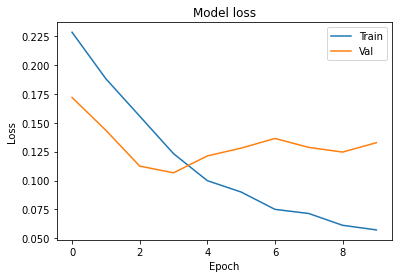

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

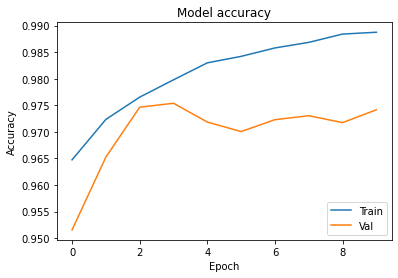

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()